In [1]:
import numpy as np 
import urdf2casadi.urdfparser as u2c
from urdf2casadi.geometry import plucker
from urdf_parser_py.urdf import URDF, Pose
import PyKDL as kdl
import kdl_parser_py.urdf as kdlurdf
from timeit import Timer, timeit, repeat
import rbdl
import pybullet as pb

In [2]:
def median(lst):
    n = len(lst)
    if n < 1:
            return None
    if n % 2 == 1:
            return sorted(lst)[n//2]
    else:
            return sum(sorted(lst)[n//2-1:n//2+1])/2.0
        
def average(lst): 
    return sum(lst) / len(lst) 


def g_kdl_func():
    for j in range(njoints):
        q_kdl[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        qdot_kdl[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2

    kdl.ChainDynParam(kdlmodel, gravity_kdl).JntToCoriolis(q_kdl, qdot_kdl, g_kdl)


def g_u2c_func():   
    for j in range(njoints):
        q_none[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        qdot_none[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2

    g_u2c(q_none, qdot_none)
    
def g_pb_func():
    for j in range(njoints):
        q_none[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        qdot_none[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
    
    g_pb = pb.calculateInverseDynamics(pbmodel, q_none, qdot_none, qddot)
    
def g_rbdl_func():
    for j in range(njoints):
        q_np[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        qdot_np[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2

    rbdl.NonlinearEffects(rbdlmodel, q_np, qdot_np, g_rbdl)

In [3]:
#pbmodel = pb.loadURDF("pantilt.urdf")
sim = pb.connect(pb.DIRECT)
#pbmodel = pb.loadURDF("/urdf4timing/1dof.urdf")
ndofs = 60
urdf_nr = list(range(ndofs + 1))
urdf_nr.pop(0)

#storage for timing data
mediantime_kdl = [None]*ndofs
mediantime_u2c = [None]*ndofs
mediantime_rbdl = [None]*ndofs
mediantime_pb = [None]*ndofs
mintime_kdl = [None]*ndofs
mintime_u2c = [None]*ndofs
mintime_rbdl = [None]*ndofs
mintime_pb = [None]*ndofs
averagetime_kdl = [None]*ndofs
averagetime_u2c = [None]*ndofs
averagetime_rbdl = [None]*ndofs
averagetime_pb = [None]*ndofs

nitr = 100
nrepeat = 100
    
for i in range(ndofs):    
    print i
    path_to_urdf = "/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/" + str(urdf_nr[i]) + "dof.urdf"
    #path_to_urdf = str(urdf_nr[i]) + "dof.urdf"
    end_link = "link" + str(urdf_nr[i])
    root = 'base_link'
    tip = end_link
    
    ok, kdl_tree = kdlurdf.treeFromFile(path_to_urdf)
    kdlmodel = kdl_tree.getChain(root,tip)
    
    rbdlmodel = rbdl.loadModel(path_to_urdf)
    pbmodel = pb.loadURDF(path_to_urdf, useFixedBase=True, flags = pb.URDF_USE_INERTIA_FROM_FILE)
    asd = u2c.URDFparser()
    robot_desc = asd.from_file(path_to_urdf)
    
    jlist, names, qmax, qmin = asd.get_joint_info(root, tip)
    njoints = len(jlist)

    gravity_kdl = kdl.Vector()
    gravity_kdl[2] = -9.81
    gravity_u2c = [0, 0, -9.81]
    
    #rbdl declarations
    q_np = np.zeros(njoints)
    qdot_np = np.zeros(njoints)
    qddot_np = np.zeros(njoints)
    g_rbdl = np.zeros(njoints)
    
    #kdl declatations
    q_kdl = kdl.JntArray(njoints)
    qdot_kdl = kdl.JntArray(njoints)
    g_kdl = kdl.JntArray(njoints)
    
    #u2c and pybullet declarations
    q_none = [None]*njoints
    qdot_none = [None]*njoints
    g_pb = [None]*njoints
    
    qddot = []
    for i in range(njoints):
        qddot.append(0.)
        
    #qdot = []
    #for i in range(njoints):
    #    qdot.append(0.)
    
    g_u2c = asd.get_coriolis_rnea(root, tip)
    timeit_u2c = repeat("g_u2c_func()", setup = "from __main__ import g_u2c_func", repeat = nrepeat, number = nitr)
    mintime_u2c[i] = min(timeit_u2c)
    mediantime_u2c[i] = median(timeit_u2c)
    averagetime_u2c[i] = average(timeit_u2c)
    
    timeit_pb = repeat("g_pb_func()", setup = "from __main__ import g_pb_func", repeat = nrepeat, number = nitr)
    mintime_pb[i] = min(timeit_pb)
    mediantime_pb[i] = median(timeit_pb)
    averagetime_pb[i] = average(timeit_pb)
    
    timeit_rbdl = repeat("g_rbdl_func()", setup = "from __main__ import g_rbdl_func", repeat = nrepeat, number = nitr)
    mintime_rbdl[i] = min(timeit_rbdl)
    mediantime_rbdl[i] = median(timeit_rbdl)
    averagetime_rbdl[i] = average(timeit_rbdl)
    
    timeit_kdl = repeat("g_kdl_func()", setup = "from __main__ import g_kdl_func", repeat = nrepeat, number = nitr)
    mintime_kdl[i] = min(timeit_kdl)
    mediantime_kdl[i] = median(timeit_kdl)
    averagetime_kdl[i] = average(timeit_kdl)


0
The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/1dof.urdf
1
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/2dof.urdf
2
The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/3dof.urdf
3
The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/4dof.urdf
4
The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.
/home/lmjo

34
The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/35dof.urdf
35
The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/36dof.urdf
36
The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/37dof.urdf
37
The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/38dof.urdf
38
T

In [11]:
mediantime_u2c =  [0.0018649101257324219, 0.0020380020141601562, 0.002242565155029297, 0.00232696533203125, 0.0025140047073364258, 0.002630472183227539, 0.0027899742126464844, 0.0029104948043823242, 0.0030965805053710938, 0.0032634735107421875, 0.003363490104675293, 0.0034868717193603516, 0.003648042678833008, 0.003741025924682617, 0.003877878189086914, 0.0040209293365478516, 0.004186868667602539, 0.004283547401428223, 0.004442930221557617, 0.004556536674499512, 0.004665970802307129, 0.0048329830169677734, 0.0049550533294677734, 0.005054473876953125, 0.005183100700378418, 0.005285024642944336, 0.005435943603515625, 0.0055435895919799805, 0.005677461624145508, 0.005832552909851074, 0.005934953689575195, 0.006042957305908203, 0.006209135055541992, 0.00637054443359375, 0.006528019905090332, 0.006613016128540039, 0.006722927093505859, 0.0069315433502197266, 0.006999969482421875, 0.007104992866516113, 0.007225990295410156, 0.007355928421020508, 0.007540583610534668, 0.0077245235443115234, 0.007776021957397461, 0.007898449897766113, 0.008052587509155273, 0.00816798210144043, 0.008330106735229492, 0.008411169052124023, 0.008539557456970215, 0.008691906929016113, 0.008825063705444336, 0.008925914764404297, 0.009078025817871094, 0.009169578552246094, 0.009279012680053711, 0.009405970573425293, 0.009485006332397461, 0.009637951850891113]
mediantime_kdl =  [0.0004031658172607422, 0.0006215572357177734, 0.0008971691131591797, 0.00102996826171875, 0.0013210773468017578, 0.0014679431915283203, 0.0016396045684814453, 0.0018398761749267578, 0.0021505355834960938, 0.0022759437561035156, 0.002485513687133789, 0.002674102783203125, 0.0028951168060302734, 0.0030624866485595703, 0.0031859874725341797, 0.003120899200439453, 0.003443002700805664, 0.003673076629638672, 0.003777027130126953, 0.003956437110900879, 0.004089832305908203, 0.004364013671875, 0.0044269561767578125, 0.00454401969909668, 0.004750967025756836, 0.004950046539306641, 0.005000114440917969, 0.005239963531494141, 0.005350470542907715, 0.005475044250488281, 0.0056580305099487305, 0.005764484405517578, 0.006448030471801758, 0.006592988967895508, 0.00672602653503418, 0.006891965866088867, 0.007004976272583008, 0.007276058197021484, 0.0073375701904296875, 0.0074939727783203125, 0.0076749324798583984, 0.0078029632568359375, 0.008044958114624023, 0.008260965347290039, 0.00839090347290039, 0.008487939834594727, 0.008650064468383789, 0.008787035942077637, 0.008917570114135742, 0.009118437767028809, 0.009406089782714844, 0.009527444839477539, 0.009628534317016602, 0.009813070297241211, 0.009793996810913086, 0.010021567344665527, 0.01032400131225586, 0.010863065719604492, 0.010550498962402344, 0.010666608810424805]
mediantime_rbdl =  [0.00025010108947753906, 0.0003654956817626953, 0.0004820823669433594, 0.0006010532379150391, 0.0007228851318359375, 0.0008414983749389648, 0.0009579658508300781, 0.0010981559753417969, 0.0012221336364746094, 0.0013508796691894531, 0.0014739036560058594, 0.0015909671783447266, 0.001716017723083496, 0.0018520355224609375, 0.0019669532775878906, 0.002133488655090332, 0.002260923385620117, 0.002371072769165039, 0.002501964569091797, 0.002610921859741211, 0.0027418136596679688, 0.002878904342651367, 0.0030308961868286133, 0.003134489059448242, 0.0032500028610229492, 0.003338456153869629, 0.0034661293029785156, 0.003641486167907715, 0.003815174102783203, 0.003972053527832031, 0.004143953323364258, 0.0042209625244140625, 0.004333376884460449, 0.004422903060913086, 0.004554033279418945, 0.004655122756958008, 0.004794120788574219, 0.004951000213623047, 0.005014896392822266, 0.005149960517883301, 0.0053141117095947266, 0.005394458770751953, 0.005578041076660156, 0.00568544864654541, 0.005808353424072266, 0.005948066711425781, 0.006102085113525391, 0.0063838958740234375, 0.006554961204528809, 0.006640076637268066, 0.006803989410400391, 0.006855010986328125, 0.007311463356018066, 0.007124543190002441, 0.0072956085205078125, 0.0073844194412231445, 0.0075414180755615234, 0.007611989974975586, 0.00777888298034668, 0.007824182510375977]
mediantime_pb =  [0.00022792816162109375, 0.00032806396484375, 0.0004291534423828125, 0.0005390644073486328, 0.0006520748138427734, 0.000759124755859375, 0.0008578300476074219, 0.0009684562683105469, 0.0010788440704345703, 0.0011868476867675781, 0.0012919902801513672, 0.0014249086380004883, 0.0015254020690917969, 0.0016238689422607422, 0.0017344951629638672, 0.0018630027770996094, 0.0019659996032714844, 0.0020530223846435547, 0.002173185348510742, 0.002270936965942383, 0.0023794174194335938, 0.0025310516357421875, 0.0026178359985351562, 0.0027320384979248047, 0.002811908721923828, 0.0029325485229492188, 0.0030341148376464844, 0.003142833709716797, 0.003247499465942383, 0.0033690929412841797, 0.0035004615783691406, 0.0035810470581054688, 0.0036804676055908203, 0.0038061141967773438, 0.003926873207092285, 0.00401151180267334, 0.004107952117919922, 0.004268527030944824, 0.00434112548828125, 0.004430532455444336, 0.004536151885986328, 0.004678010940551758, 0.004776477813720703, 0.004934787750244141, 0.005032539367675781, 0.005139946937561035, 0.00530695915222168, 0.005345821380615234, 0.005503535270690918, 0.005629539489746094, 0.0057239532470703125, 0.0058019161224365234, 0.005970001220703125, 0.006013035774230957, 0.006157994270324707, 0.006358504295349121, 0.006348013877868652, 0.006481051445007324, 0.006635904312133789, 0.006703495979309082]


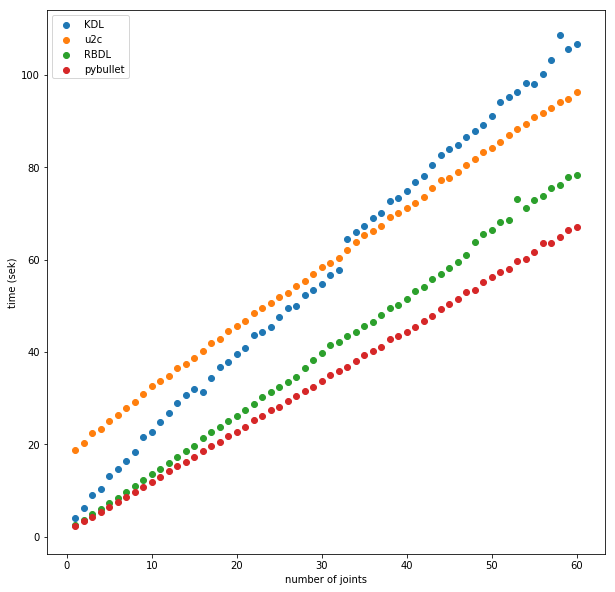

In [12]:
for i in range(ndofs):
    mediantime_u2c[i] = mediantime_u2c[i]/nitr*1000000
    mediantime_pb[i] = mediantime_pb[i]/nitr*1000000
    mediantime_rbdl[i] = mediantime_rbdl[i]/nitr*1000000
    mediantime_kdl[i] = mediantime_kdl[i]/nitr*1000000

import matplotlib.pyplot as plt
import pandas as pd
joint_nr = list(range(ndofs + 1))
joint_nr.pop(0)
med_fig = plt.figure(figsize = (10, 10))
plt.scatter(joint_nr, mediantime_kdl, label='KDL')
#plt.scatter(joint_nr, mediantime_u2c, c='hotpink', label='u2c')
plt.scatter(joint_nr, mediantime_u2c, label='u2c')
plt.scatter(joint_nr, mediantime_rbdl, label='RBDL')
plt.scatter(joint_nr, mediantime_pb, label='pybullet')
plt.xlabel("number of joints")
plt.ylabel("time (sek)")
plt.legend(loc='upper left')
med_fig.show()

[Text(0,0,'pybullet'), Text(0,0,'RBDL'), Text(0,0,'U2C'), Text(0,0,'KDL')]

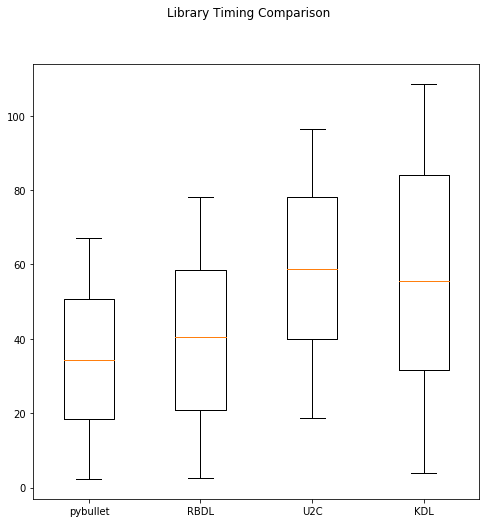

In [13]:
timing_scores = [mediantime_pb, mediantime_rbdl, mediantime_u2c, mediantime_kdl]
names = ["pybullet", "RBDL", "U2C", "KDL"]#, "RBDL", "pybullet"]
boxplot = plt.figure(figsize = (8, 8))
boxplot.suptitle("Library Timing Comparison")
ax = boxplot.add_subplot(111)
ax.boxplot(timing_scores)
#plt.boxplot(timing_scores)
ax.set_xticklabels(names)


In [14]:

print "mediantime_u2c = ",mediantime_u2c

print "mediantime_kdl = ",mediantime_kdl

print "mediantime_rbdl = ",mediantime_rbdl

print "mediantime_pb = ",mediantime_pb

mediantime_u2c =  [18.64910125732422, 20.380020141601562, 22.42565155029297, 23.2696533203125, 25.140047073364258, 26.30472183227539, 27.899742126464844, 29.104948043823242, 30.965805053710938, 32.634735107421875, 33.63490104675293, 34.868717193603516, 36.48042678833008, 37.41025924682617, 38.77878189086914, 40.209293365478516, 41.86868667602539, 42.83547401428223, 44.42930221557617, 45.56536674499512, 46.65970802307129, 48.329830169677734, 49.550533294677734, 50.54473876953125, 51.83100700378418, 52.85024642944336, 54.35943603515625, 55.435895919799805, 56.77461624145508, 58.32552909851074, 59.34953689575195, 60.42957305908203, 62.09135055541992, 63.7054443359375, 65.28019905090332, 66.13016128540039, 67.2292709350586, 69.31543350219727, 69.99969482421875, 71.04992866516113, 72.25990295410156, 73.55928421020508, 75.40583610534668, 77.24523544311523, 77.76021957397461, 78.98449897766113, 80.52587509155273, 81.6798210144043, 83.30106735229492, 84.11169052124023, 85.39557456970215, 86.91

In [ ]:
mediantime_u2c =  [18.64910125732422, 20.380020141601562, 22.42565155029297, 23.2696533203125, 25.140047073364258, 26.30472183227539, 27.899742126464844, 29.104948043823242, 30.965805053710938, 32.634735107421875, 33.63490104675293, 34.868717193603516, 36.48042678833008, 37.41025924682617, 38.77878189086914, 40.209293365478516, 41.86868667602539, 42.83547401428223, 44.42930221557617, 45.56536674499512, 46.65970802307129, 48.329830169677734, 49.550533294677734, 50.54473876953125, 51.83100700378418, 52.85024642944336, 54.35943603515625, 55.435895919799805, 56.77461624145508, 58.32552909851074, 59.34953689575195, 60.42957305908203, 62.09135055541992, 63.7054443359375, 65.28019905090332, 66.13016128540039, 67.2292709350586, 69.31543350219727, 69.99969482421875, 71.04992866516113, 72.25990295410156, 73.55928421020508, 75.40583610534668, 77.24523544311523, 77.76021957397461, 78.98449897766113, 80.52587509155273, 81.6798210144043, 83.30106735229492, 84.11169052124023, 85.39557456970215, 86.91906929016113, 88.25063705444336, 89.25914764404297, 90.78025817871094, 91.69578552246094, 92.79012680053711, 94.05970573425293, 94.85006332397461, 96.37951850891113]
mediantime_kdl =  [4.031658172607422, 6.215572357177734, 8.971691131591797, 10.2996826171875, 13.210773468017578, 14.679431915283203, 16.396045684814453, 18.398761749267578, 21.505355834960938, 22.759437561035156, 24.85513687133789, 26.74102783203125, 28.951168060302734, 30.6248664855957, 31.859874725341797, 31.20899200439453, 34.43002700805664, 36.73076629638672, 37.77027130126953, 39.56437110900879, 40.89832305908203, 43.64013671875, 44.269561767578125, 45.4401969909668, 47.50967025756836, 49.500465393066406, 50.00114440917969, 52.399635314941406, 53.50470542907715, 54.75044250488281, 56.580305099487305, 57.64484405517578, 64.48030471801758, 65.92988967895508, 67.2602653503418, 68.91965866088867, 70.04976272583008, 72.76058197021484, 73.37570190429688, 74.93972778320312, 76.74932479858398, 78.02963256835938, 80.44958114624023, 82.60965347290039, 83.9090347290039, 84.87939834594727, 86.50064468383789, 87.87035942077637, 89.17570114135742, 91.18437767028809, 94.06089782714844, 95.27444839477539, 96.28534317016602, 98.13070297241211, 97.93996810913086, 100.21567344665527, 103.2400131225586, 108.63065719604492, 105.50498962402344, 106.66608810424805]
mediantime_rbdl =  [2.5010108947753906, 3.654956817626953, 4.820823669433594, 6.010532379150391, 7.228851318359375, 8.414983749389648, 9.579658508300781, 10.981559753417969, 12.221336364746094, 13.508796691894531, 14.739036560058594, 15.909671783447267, 17.16017723083496, 18.520355224609375, 19.669532775878906, 21.33488655090332, 22.609233856201172, 23.71072769165039, 25.01964569091797, 26.10921859741211, 27.418136596679688, 28.789043426513672, 30.308961868286133, 31.344890594482422, 32.50002861022949, 33.38456153869629, 34.661293029785156, 36.41486167907715, 38.15174102783203, 39.72053527832031, 41.43953323364258, 42.209625244140625, 43.33376884460449, 44.22903060913086, 45.54033279418945, 46.55122756958008, 47.94120788574219, 49.51000213623047, 50.148963928222656, 51.49960517883301, 53.141117095947266, 53.94458770751953, 55.78041076660156, 56.8544864654541, 58.083534240722656, 59.48066711425781, 61.020851135253906, 63.838958740234375, 65.54961204528809, 66.40076637268066, 68.0398941040039, 68.55010986328125, 73.11463356018066, 71.24543190002441, 72.95608520507812, 73.84419441223145, 75.41418075561523, 76.11989974975586, 77.7888298034668, 78.24182510375977]
mediantime_pb =  [2.2792816162109375, 3.2806396484375, 4.291534423828125, 5.390644073486328, 6.520748138427734, 7.59124755859375, 8.578300476074219, 9.684562683105469, 10.788440704345703, 11.868476867675781, 12.919902801513672, 14.249086380004883, 15.254020690917969, 16.238689422607422, 17.344951629638672, 18.630027770996094, 19.659996032714844, 20.530223846435547, 21.731853485107422, 22.709369659423828, 23.794174194335938, 25.310516357421875, 26.178359985351562, 27.320384979248047, 28.11908721923828, 29.325485229492188, 30.341148376464844, 31.42833709716797, 32.47499465942383, 33.6909294128418, 35.004615783691406, 35.81047058105469, 36.8046760559082, 38.06114196777344, 39.26873207092285, 40.1151180267334, 41.07952117919922, 42.68527030944824, 43.4112548828125, 44.30532455444336, 45.36151885986328, 46.78010940551758, 47.76477813720703, 49.347877502441406, 50.32539367675781, 51.39946937561035, 53.0695915222168, 53.458213806152344, 55.03535270690918, 56.29539489746094, 57.239532470703125, 58.019161224365234, 59.70001220703125, 60.13035774230957, 61.57994270324708, 63.58504295349121, 63.48013877868652, 64.81051445007324, 66.35904312133789, 67.03495979309082]